In [67]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

def plot_perf(results_file, sub_title):
    # os exec: "make sync" (redirect stdout and stderr to /dev/null)
    os.system("make sync > /dev/null 2>&1")

    data_dict = {}

    # Read data from the file
    with open(results_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                items = line.split('\t')
                row = {}
                for item in items:
                    key, value = item.split('=')
                    row[key] = value

                # Extract configuration parameters to form a unique key
                config_keys = ['ARCH', 'BATCH_SIZE', 'EMBED_DIM', 'HIDDEN_DIM', 'Q']
                config = tuple(row[key] for key in config_keys)

                # Initialize the entry if it's a new configuration
                if config not in data_dict:
                    # Initialize with configuration parameters
                    data_dict[config] = {k: row[k] for k in config_keys}

                # Add kernel times to the entry
                for key in row:
                    if key not in config_keys:
                        data_dict[config][key] = row[key]

    # Convert the data_dict to a list of dictionaries
    data = list(data_dict.values())

    # Create DataFrame
    df = pd.DataFrame(data)

    # Convert columns to appropriate data types
    for col in df.columns:
        if col != 'ARCH':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Map ARCH values to A800 and H800
    df['ARCH'] = df['ARCH'].map({'a01': 'A800', 'h01': 'H800'})

    # Compute combined kernels
    kernel_bases = ['DENSE', 'DEJAVU', 'NEO']
    for kernel in kernel_bases:
        up_col = 'UP_' + kernel
        down_col = 'DOWN_' + kernel
        combined_col = 'COMBINED_' + kernel
        # Check if both UP and DOWN columns exist
        if up_col in df.columns and down_col in df.columns:
            # Compute combined time where both UP and DOWN times are available
            df[combined_col] = df[up_col] + df[down_col]
            # If either UP or DOWN time is missing, set combined time to NaN
            df[combined_col] = df[combined_col].where(df[up_col].notna() & df[down_col].notna(), np.nan)

    # Separate data for A800 and H800
    df_A800 = df[df['ARCH'] == 'A800']
    df_H800 = df[df['ARCH'] == 'H800']

    # Sort the data by 'Q'
    df_A800 = df_A800.sort_values(by='Q')
    df_H800 = df_H800.sort_values(by='Q')

    # Set seaborn style
    sns.set_style('whitegrid')

    # Create figure with 6 subplots (2 rows x 3 columns)
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))

    # Adjust space between subplots
    plt.subplots_adjust(hspace=0.4)

    # Plot A800 UP Kernels
    ax1 = axes[0, 0]
    for kernel in ['UP_DENSE', 'UP_DEJAVU', 'UP_NEO', 'UP_CATS']:
        if kernel in df_A800.columns:
            ax1.plot(df_A800['Q'], df_A800[kernel], marker='o', label=kernel)
    ax1.set_xlabel('Q')
    ax1.set_ylabel('Time (s)')
    ax1.set_title('A800 UP Kernels (' + sub_title + ')')
    ax1.legend()

    # Plot A800 DOWN Kernels
    ax2 = axes[0, 1]
    for kernel in ['DOWN_DENSE', 'DOWN_DEJAVU', 'DOWN_NEO', 'DOWN_SPLITK']:
        if kernel in df_A800.columns:
            ax2.plot(df_A800['Q'], df_A800[kernel], marker='o', label=kernel)
    ax2.set_xlabel('Q')
    ax2.set_ylabel('Time (s)')
    ax2.set_title('A800 DOWN Kernels (' + sub_title + ')')
    ax2.legend()

    # Plot H800 UP Kernels
    ax3 = axes[1, 0]
    for kernel in ['UP_DENSE', 'UP_DEJAVU', 'UP_NEO', 'UP_CATS']:
        if kernel in df_H800.columns:
            ax3.plot(df_H800['Q'], df_H800[kernel], marker='o', label=kernel)
    ax3.set_xlabel('Q')
    ax3.set_ylabel('Time (s)')
    ax3.set_title('H800 UP Kernels (' + sub_title + ')')
    ax3.legend()

    # Plot H800 DOWN Kernels
    ax4 = axes[1, 1]
    for kernel in ['DOWN_DENSE', 'DOWN_DEJAVU', 'DOWN_NEO', 'DOWN_SPLITK']:
        if kernel in df_H800.columns:
            ax4.plot(df_H800['Q'], df_H800[kernel], marker='o', label=kernel)
    ax4.set_xlabel('Q')
    ax4.set_ylabel('Time (s)')
    ax4.set_title('H800 DOWN Kernels (' + sub_title + ')')
    ax4.legend()

    # Plot A800 COMBINED Kernels
    ax5 = axes[0, 2]
    for kernel in ['COMBINED_DENSE', 'COMBINED_DEJAVU', 'COMBINED_NEO']:
        if kernel in df_A800.columns:
            ax5.plot(df_A800['Q'], df_A800[kernel], marker='o', label=kernel)
    ax5.set_xlabel('Q')
    ax5.set_ylabel('Time (s)')
    ax5.set_title('A800 COMBINED Kernels (' + sub_title + ')')
    ax5.legend()

    # Plot H800 COMBINED Kernels
    ax6 = axes[1, 2]
    for kernel in ['COMBINED_DENSE', 'COMBINED_DEJAVU', 'COMBINED_NEO']:
        if kernel in df_H800.columns:
            ax6.plot(df_H800['Q'], df_H800[kernel], marker='o', label=kernel)
    ax6.set_xlabel('Q')
    ax6.set_ylabel('Time (s)')
    ax6.set_title('H800 COMBINED Kernels (' + sub_title + ')')
    ax6.legend()

    plt.tight_layout()
    plt.show()


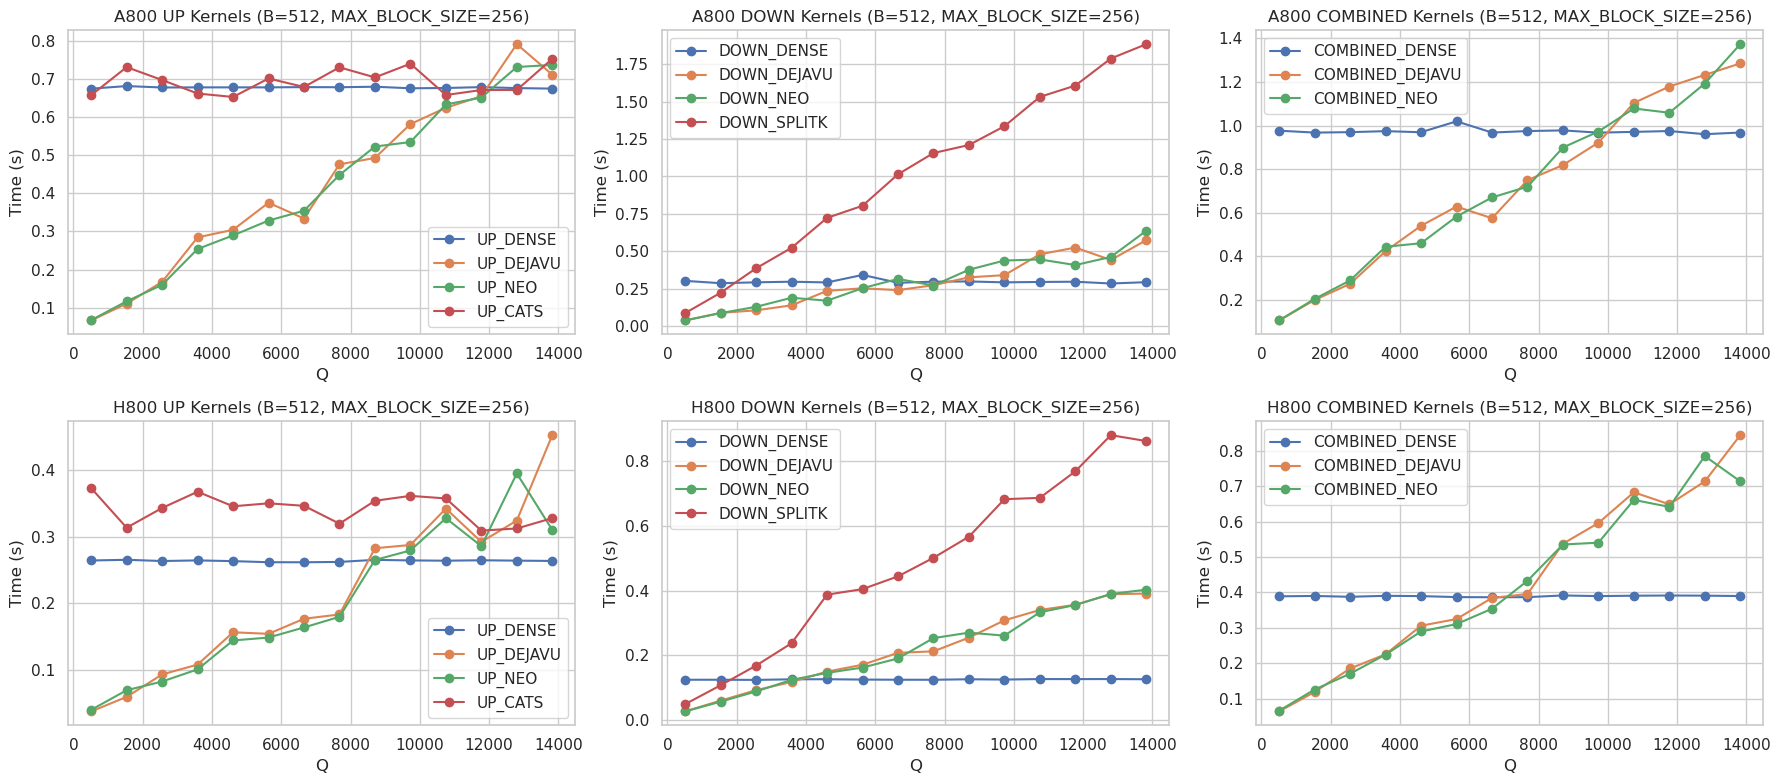

In [68]:
plot_perf('results/kernel-results-13b-b512-m256.txt', 'B=512, MAX_BLOCK_SIZE=256')


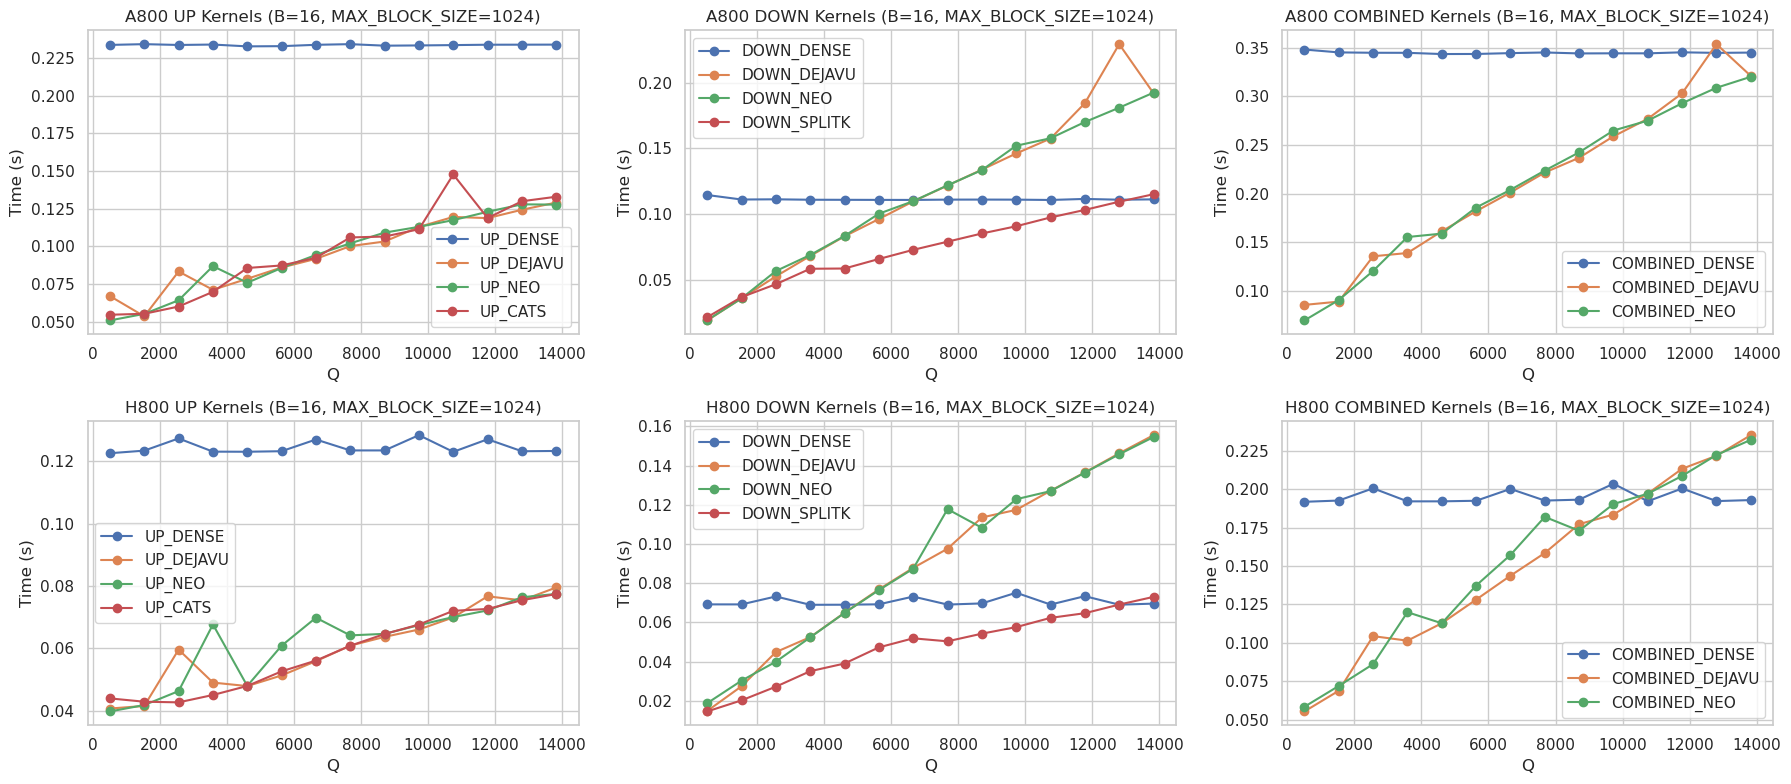

In [69]:
plot_perf('results/kernel-results-13b-b16-m1024.txt', 'B=16, MAX_BLOCK_SIZE=1024')

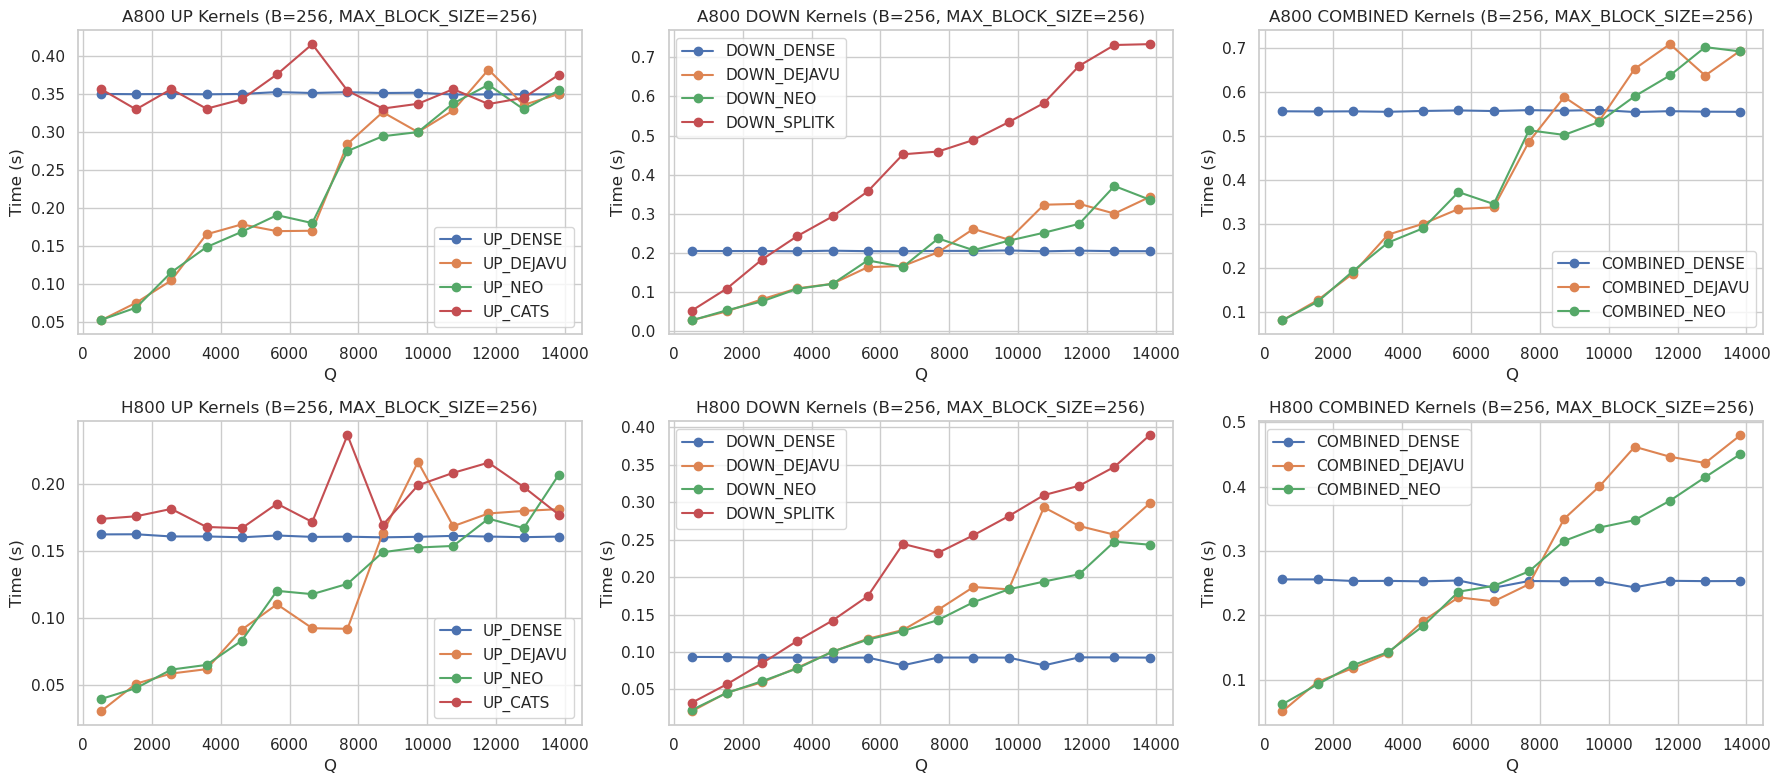

In [81]:
plot_perf('results/kernel-results-13b-b256-m256.txt', 'B=256, MAX_BLOCK_SIZE=256')

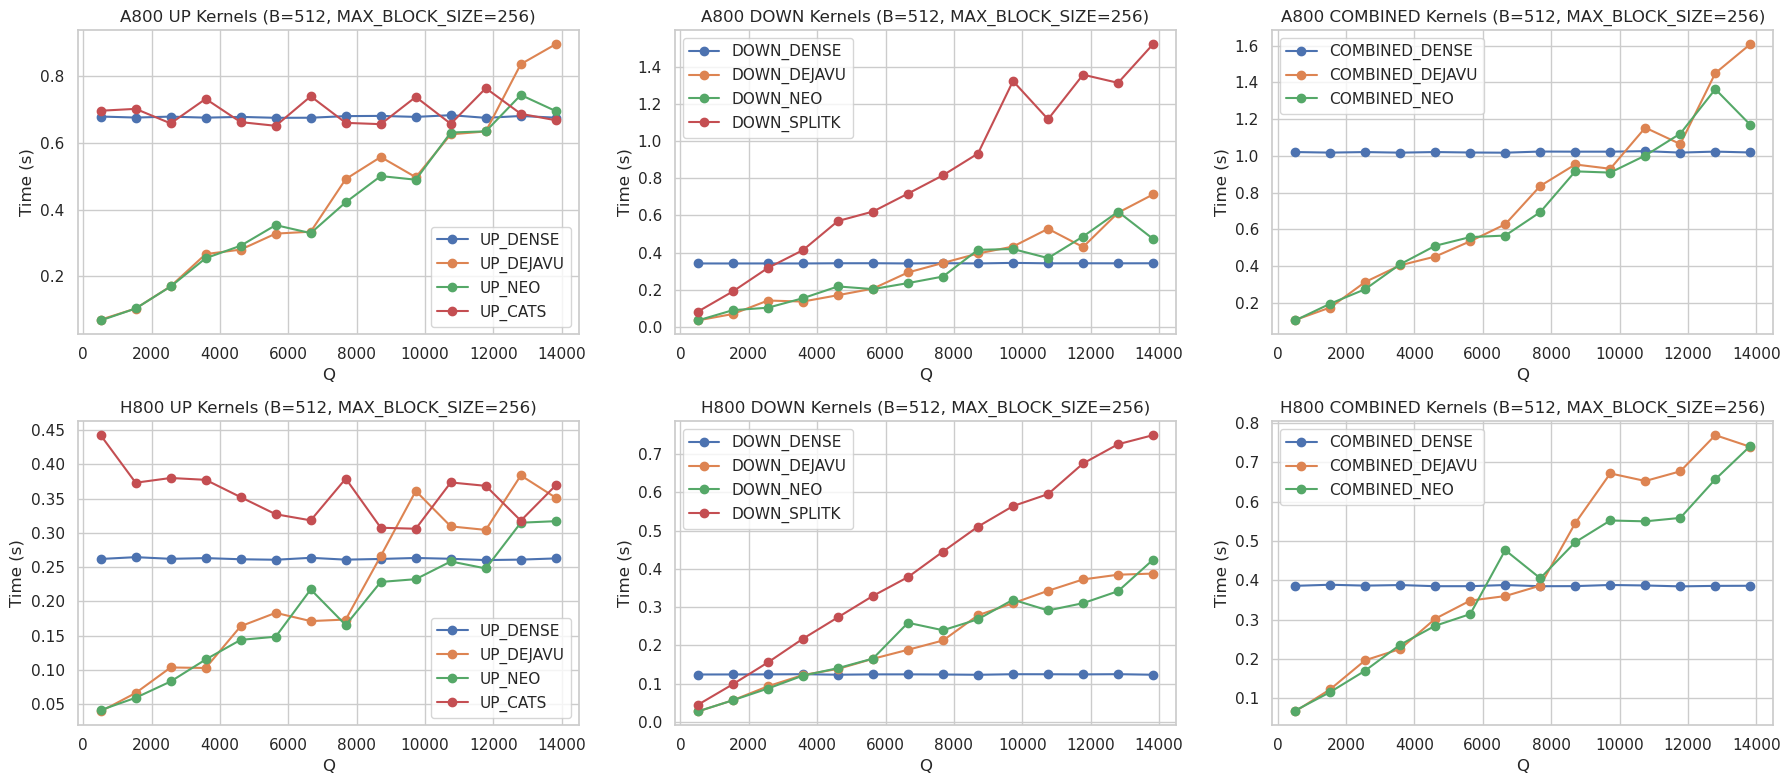

In [93]:
plot_perf('sbatch-results/kernel-results.txt', 'B=512, MAX_BLOCK_SIZE=256')